In [1]:
%matplotlib notebook
#add comments
import os
import sys
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc, create_spec, load_wav
from glob import glob

from torch.utils.data import Dataset
from CustomAudioDataset import CustomAudioDataset

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd

from TweetyNetModel import TweetyNetModel  

from pydub import AudioSegment
import os

In [45]:
import pydub
train = True
fineTuning = False
#needs at least 80 for mel spectrograms ## may be able to do a little less, but must be greater than 60
n_mels=72 # The closest we can get tmeporally is 72 with an output of 432 : i think it depends on whats good
#this number should be proportional to the length of the videos. 
num_workers=2

data = pd.read_csv("C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing/automated_cosmos_tweety_to_file.csv")
datasets_dir = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/Cosmos_data"
this_is_new_data = False
path_to_audio = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing"
data_path = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
data_path = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
new_folder = data_path
AudioSegment.converter = "C:/Users/siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"
pydub.AudioSegment.ffmpeg = "C:/Users/siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"


In [3]:
main_data_location = ".\cosmos_data\Cosmos_data"

In [4]:
import pandas as pd
import numpy as np


#TODO Add mutliple species support for ROC curves 
def annotation_chunker_no_duplicates(kaleidoscope_df, chunk_length, include_no_bird=False, bird=None):
    """
    Function that converts a Kaleidoscope-formatted Dataframe containing 
    annotations to uniform chunks of chunk_length. If there
    are mutliple bird species in the same clip, this function creates chunks
    for the more confident bird species.

    Note: if all or part of an annotation covers the last < chunk_length
    seconds of a clip it will be ignored. If two annotations overlap in 
    the same 3 second chunk, both are represented in that chunk
    Args:
        kaleidoscope_df (Dataframe)
            - Dataframe of annotations in kaleidoscope format

        chunk_length (int)
            - duration to set all annotation chunks
    Returns:
        Dataframe of labels with chunk_length duration 
        (elements in "OFFSET" are divisible by chunk_length).
    """

    #Init list of clips to cycle through and output dataframe
    #kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"] 
    kaleidoscope_df['FILEPATH'] = kaleidoscope_df.loc[:,['FOLDER','IN FILE']].sum(axis=1)
    clips = kaleidoscope_df["FILEPATH"].unique()
    df_columns = {'FOLDER': 'str', 'IN FILE' :'str', 'CLIP LENGTH' : 'float64', 'CHANNEL' : 'int64', 'OFFSET' : 'float64',
                'DURATION' : 'float64', 'SAMPLE RATE' : 'int64','MANUAL ID' : 'str'}
    output_df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in df_columns.items()})
    
    # going through each clip
    for clip in clips:
        clip_df = kaleidoscope_df[kaleidoscope_df["FILEPATH"] == clip]
        path = clip_df["FOLDER"].unique()[0]
        file = clip_df["IN FILE"].unique()[0]
        birds = clip_df["MANUAL ID"].unique()
        sr = clip_df["SAMPLE RATE"].unique()[0]
        clip_len = clip_df["CLIP LENGTH"].unique()[0]

        # quick data sanitization to remove very short clips
        # do not consider any chunk that is less than chunk_length
        if clip_len < chunk_length:
            continue
        potential_annotation_count = int(clip_len)//int(chunk_length)

        # going through each species that was ID'ed in the clip
        arr_len = int(clip_len*1000)
        species_df = clip_df#[clip_df["MANUAL ID"] == bird]
        human_arr = np.zeros((arr_len))
        # looping through each annotation
        #print("========================================")
        for annotation in species_df.index:
            #print(species_df["OFFSET"][annotation])
            minval = int(round(species_df["OFFSET"][annotation] * 1000, 0))
            # Determining the end of a human label
            maxval = int(
                round(
                    (species_df["OFFSET"][annotation] +
                        species_df["DURATION"][annotation]) *
                    1000,
                    0))
            # Placing the label relative to the clip
            human_arr[minval:maxval] = 1
        # performing the chunk isolation technique on the human array

        for index in range(potential_annotation_count):
            #print("=======================")
            #print("-----------------------------------------")
            #print(index)
            chunk_start = index * (chunk_length*1000)
            chunk_end = min((index+1)*chunk_length*1000,arr_len)
            chunk = human_arr[int(chunk_start):int(chunk_end)]
            if max(chunk) >= 0.5:
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #Handle birdnet output edge case
                #print("-------------------------------------------")
                #print(sum(clip_df["DURATION"] == 3))
                #print(sum(clip_df["DURATION"] == 3)/clip_df.shape[0])
                #print("-------------------------------------------")
                if(sum(clip_df["DURATION"] == 3)/clip_df.shape[0] == 1):
                    #print("Processing here duration")
                    overlap = (clip_df["OFFSET"]+0.5 >= (annotation_start)) & (clip_df["OFFSET"]-0.5 <= (annotation_start))
                    annotation_df = clip_df[overlap]
                    #print(annotation_start, np.array(clip_df["OFFSET"]), overlap)
                    #print(annotation_df)
                else:
                    #print("Processing here")
                    overlap = is_overlap(clip_df["OFFSET"], clip_df["OFFSET"] + clip_df["DURATION"], annotation_start, annotation_start + chunk_length)
                    #print(overlap)
                    annotation_df = clip_df[overlap]
                    #print(annotation_df)
                
                #updating the dictionary
                if ('CONFIDENCE' in clip_df.columns):
                    annotation_df = annotation_df.sort_values(by="CONFIDENCE", ascending=False)
                    row["CONFIDENCE"] = annotation_df.iloc[0]["CONFIDENCE"]
                else:
                    #The case of manual id, or there is an annotation with no known confidence
                    row["CONFIDENCE"] = 1
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = annotation_df.iloc[0]["MANUAL ID"] 
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
            elif(include_no_bird):
                #print(max(chunk))
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #updating the dictionary
                row["CONFIDENCE"] = 0
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = "no bird"
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
    
    return output_df


def is_overlap(offset_df, end_df, chunk_start, chunk_end):
    is_both_before = (chunk_end < offset_df) & (chunk_start < offset_df)
    is_both_after = (end_df < chunk_end) & (end_df < chunk_start)
    return (~is_both_before) & (~is_both_after)
    
    
    interval = pd.Interval(left=offset_df, right=end_df)
    print(interval)


def split_save_files(dataframe_of_data):
    chunked_df = annotation_chunker_no_duplicates(dataframe_of_data, 3, include_no_bird=True)
    
    
    chunked_df.apply()
    

In [5]:


#
chunked_df = annotation_chunker_no_duplicates(data, 3, include_no_bird=True)
chunked_df

FOLDER  \
0      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4      C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...                                         ...   
39720  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39721  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39722  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39723  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39724  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
0      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
1      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
2      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
3      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
4      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
...                                                  ...          ...   
39720  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39721  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39722  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39723  XC9881 - Blue-grey Tanager - Thraupis episcopu...    14.700000   
39724  XC99284 - Slate-throated Whitestart - Myioboru...     3.369796   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE                 MANUAL ID  \
0            0     0.0       3.0        44100  Microcerculus marginatus   
1            0     3.0       3.0        44100  Microcerculus marginatus   
2            0     6.0       3.0        44100  Microcerculus marginatus   
3            0     9.0       3.0        44100  Microcerculus marginatus   
4            0    12.0       3.0        44100  Microcerculus marginatus   
...        ...     ...       ...          ...                       ...   
39720        0     0.0       3.0        44100        Thraupis episcopus   
39721        0     3.0       3.0        44100        Thraupis episcopus   
39722        0     6.0       3.0        44100        Thraupis episcopus   
39723        0     9.0       3.0        44100                   no bird   
39724        0     0.0       3.0        44100        Myioborus miniatus   

       CONFIDENCE  
0        0.543653  
1        0.230806  
2        0.544028  
3        0.793030  
4        0.299593  
...           ...  
39720    0.943661  
39721    0.775321  
39722    0.775321  
39723    0.000000  
39724    1.000000  

[39725 rows x 9 columns]

In [6]:
chunked_df.iloc[0]["IN FILE"]

'XC100027 - Southern Nightingale-Wren - Microcerculus marginatus.mp3'

In [7]:
import pydub


In [8]:
from pydub import AudioSegment

import os

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_to_audio) if isfile(join(path_to_audio, f))]
chunked_df = chunked_df[chunked_df["IN FILE"].isin(onlyfiles)]


chunked_renamed_df = chunked_df.copy()
count = 0
for filename in np.unique(chunked_df["IN FILE"]):
    file_df = chunked_df[chunked_df["IN FILE"] == filename]
    if (len(filename.split(".")) != 2):
        break
    file, file_type = filename.split(".")
    for index,row in file_df.iterrows():
        t1 = row["OFFSET"] * 1000
        # end time in milliseconds
        t2 = (row["OFFSET"] + 3) * 1000
        new_name = file + "_" + str(int(row["OFFSET"])) +"." + file_type
        new_path = new_folder + "/" + new_name
        
        if(this_is_new_data):
            newAudio = AudioSegment.from_mp3(path_to_audio + "/" + filename)
            newAudio = newAudio[t1:t2]
            newAudio.export(new_path, format="mp3")

        chunked_renamed_df.at[index, "IN FILE"] = new_name
        chunked_renamed_df.at[index, "FOLDER"] = new_folder
        count += 1
        print(count, "out of 6451")

        
chunked_renamed_df = chunked_renamed_df[chunked_renamed_df["IN FILE"] != "TO DELETE"]
chunked_renamed_df
    
    

1 out of 6451
2 out of 6451
3 out of 6451
4 out of 6451
5 out of 6451
6 out of 6451
7 out of 6451
8 out of 6451
9 out of 6451
10 out of 6451
11 out of 6451
12 out of 6451
13 out of 6451
14 out of 6451
15 out of 6451
16 out of 6451
17 out of 6451
18 out of 6451
19 out of 6451
20 out of 6451
21 out of 6451
22 out of 6451
23 out of 6451
24 out of 6451
25 out of 6451
26 out of 6451
27 out of 6451
28 out of 6451
29 out of 6451
30 out of 6451
31 out of 6451
32 out of 6451
33 out of 6451
34 out of 6451
35 out of 6451
36 out of 6451
37 out of 6451
38 out of 6451
39 out of 6451
40 out of 6451
41 out of 6451
42 out of 6451
43 out of 6451
44 out of 6451
45 out of 6451
46 out of 6451
47 out of 6451
48 out of 6451
49 out of 6451
50 out of 6451
51 out of 6451
52 out of 6451
53 out of 6451
54 out of 6451
55 out of 6451
56 out of 6451
57 out of 6451
58 out of 6451
59 out of 6451
60 out of 6451
61 out of 6451
62 out of 6451
63 out of 6451
64 out of 6451
65 out of 6451
66 out of 6451
67 out of 6451
68 o

890 out of 6451
891 out of 6451
892 out of 6451
893 out of 6451
894 out of 6451
895 out of 6451
896 out of 6451
897 out of 6451
898 out of 6451
899 out of 6451
900 out of 6451
901 out of 6451
902 out of 6451
903 out of 6451
904 out of 6451
905 out of 6451
906 out of 6451
907 out of 6451
908 out of 6451
909 out of 6451
910 out of 6451
911 out of 6451
912 out of 6451
913 out of 6451
914 out of 6451
915 out of 6451
916 out of 6451
917 out of 6451
918 out of 6451
919 out of 6451
920 out of 6451
921 out of 6451
922 out of 6451
923 out of 6451
924 out of 6451
925 out of 6451
926 out of 6451
927 out of 6451
928 out of 6451
929 out of 6451
930 out of 6451
931 out of 6451
932 out of 6451
933 out of 6451
934 out of 6451
935 out of 6451
936 out of 6451
937 out of 6451
938 out of 6451
939 out of 6451
940 out of 6451
941 out of 6451
942 out of 6451
943 out of 6451
944 out of 6451
945 out of 6451
946 out of 6451
947 out of 6451
948 out of 6451
949 out of 6451
950 out of 6451
951 out of 6451
952 out 

1847 out of 6451
1848 out of 6451
1849 out of 6451
1850 out of 6451
1851 out of 6451
1852 out of 6451
1853 out of 6451
1854 out of 6451
1855 out of 6451
1856 out of 6451
1857 out of 6451
1858 out of 6451
1859 out of 6451
1860 out of 6451
1861 out of 6451
1862 out of 6451
1863 out of 6451
1864 out of 6451
1865 out of 6451
1866 out of 6451
1867 out of 6451
1868 out of 6451
1869 out of 6451
1870 out of 6451
1871 out of 6451
1872 out of 6451
1873 out of 6451
1874 out of 6451
1875 out of 6451
1876 out of 6451
1877 out of 6451
1878 out of 6451
1879 out of 6451
1880 out of 6451
1881 out of 6451
1882 out of 6451
1883 out of 6451
1884 out of 6451
1885 out of 6451
1886 out of 6451
1887 out of 6451
1888 out of 6451
1889 out of 6451
1890 out of 6451
1891 out of 6451
1892 out of 6451
1893 out of 6451
1894 out of 6451
1895 out of 6451
1896 out of 6451
1897 out of 6451
1898 out of 6451
1899 out of 6451
1900 out of 6451
1901 out of 6451
1902 out of 6451
1903 out of 6451
1904 out of 6451
1905 out of 64

2765 out of 6451
2766 out of 6451
2767 out of 6451
2768 out of 6451
2769 out of 6451
2770 out of 6451
2771 out of 6451
2772 out of 6451
2773 out of 6451
2774 out of 6451
2775 out of 6451
2776 out of 6451
2777 out of 6451
2778 out of 6451
2779 out of 6451
2780 out of 6451
2781 out of 6451
2782 out of 6451
2783 out of 6451
2784 out of 6451
2785 out of 6451
2786 out of 6451
2787 out of 6451
2788 out of 6451
2789 out of 6451
2790 out of 6451
2791 out of 6451
2792 out of 6451
2793 out of 6451
2794 out of 6451
2795 out of 6451
2796 out of 6451
2797 out of 6451
2798 out of 6451
2799 out of 6451
2800 out of 6451
2801 out of 6451
2802 out of 6451
2803 out of 6451
2804 out of 6451
2805 out of 6451
2806 out of 6451
2807 out of 6451
2808 out of 6451
2809 out of 6451
2810 out of 6451
2811 out of 6451
2812 out of 6451
2813 out of 6451
2814 out of 6451
2815 out of 6451
2816 out of 6451
2817 out of 6451
2818 out of 6451
2819 out of 6451
2820 out of 6451
2821 out of 6451
2822 out of 6451
2823 out of 64

3609 out of 6451
3610 out of 6451
3611 out of 6451
3612 out of 6451
3613 out of 6451
3614 out of 6451
3615 out of 6451
3616 out of 6451
3617 out of 6451
3618 out of 6451
3619 out of 6451
3620 out of 6451
3621 out of 6451
3622 out of 6451
3623 out of 6451
3624 out of 6451
3625 out of 6451
3626 out of 6451
3627 out of 6451
3628 out of 6451
3629 out of 6451
3630 out of 6451
3631 out of 6451
3632 out of 6451
3633 out of 6451
3634 out of 6451
3635 out of 6451
3636 out of 6451
3637 out of 6451
3638 out of 6451
3639 out of 6451
3640 out of 6451
3641 out of 6451
3642 out of 6451
3643 out of 6451
3644 out of 6451
3645 out of 6451
3646 out of 6451
3647 out of 6451
3648 out of 6451
3649 out of 6451
3650 out of 6451
3651 out of 6451
3652 out of 6451
3653 out of 6451
3654 out of 6451
3655 out of 6451
3656 out of 6451
3657 out of 6451
3658 out of 6451
3659 out of 6451
3660 out of 6451
3661 out of 6451
3662 out of 6451
3663 out of 6451
3664 out of 6451
3665 out of 6451
3666 out of 6451
3667 out of 64

4108 out of 6451
4109 out of 6451
4110 out of 6451
4111 out of 6451
4112 out of 6451
4113 out of 6451
4114 out of 6451
4115 out of 6451
4116 out of 6451
4117 out of 6451
4118 out of 6451
4119 out of 6451
4120 out of 6451
4121 out of 6451
4122 out of 6451
4123 out of 6451
4124 out of 6451
4125 out of 6451
4126 out of 6451
4127 out of 6451
4128 out of 6451
4129 out of 6451
4130 out of 6451
4131 out of 6451
4132 out of 6451
4133 out of 6451
4134 out of 6451
4135 out of 6451
4136 out of 6451
4137 out of 6451
4138 out of 6451
4139 out of 6451
4140 out of 6451
4141 out of 6451
4142 out of 6451
4143 out of 6451
4144 out of 6451
4145 out of 6451
4146 out of 6451
4147 out of 6451
4148 out of 6451
4149 out of 6451
4150 out of 6451
4151 out of 6451
4152 out of 6451
4153 out of 6451
4154 out of 6451
4155 out of 6451
4156 out of 6451
4157 out of 6451
4158 out of 6451
4159 out of 6451
4160 out of 6451
4161 out of 6451
4162 out of 6451
4163 out of 6451
4164 out of 6451
4165 out of 6451
4166 out of 64

FOLDER  \
201    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
202    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
203    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
268    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
269    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
...                                                  ...   
39653           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39654           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39655           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39656           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39657           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
201    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
202    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
203    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
268    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
269    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
39653  XC97532 - Blue-grey Tanager - Thraupis episcop...    20.297143   
39654  XC97542 - Slate-throated Whitestart - Myioboru...     4.362449   
39655  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39656  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39657  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
201          0     0.0       3.0        44100  Zonotrichia capensis   
202          0     3.0       3.0        44100  Zonotrichia capensis   
203          0     6.0       3.0        44100  Zonotrichia capensis   
268          0     0.0       3.0        44100     Turdus leucomelas   
269          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
39653        0    15.0       3.0        44100    Thraupis episcopus   
39654        0     0.0       3.0        44100    Myioborus miniatus   
39655        0     0.0       3.0        44100  Zonotrichia capensis   
39656        0     3.0       3.0        44100  Zonotrichia capensis   
39657        0     6.0       3.0        44100  Zonotrichia capensis   

       CONFIDENCE  
201      0.914495  
202      0.157588  
203      1.000000  
268      0.743005  
269      0.842912  
...           ...  
39653    0.282231  
39654    0.977568  
39655    0.583067  
39656    0.648309  
39657    0.668926  

[6451 rows x 9 columns]

In [9]:
x = chunked_renamed_df.groupby(["IN FILE", "OFFSET"]).count().sort_values(by="MANUAL ID", ascending=False)
x.shape[0]

6451

In [10]:
def show_mel_spectrogram(spec, uid):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title=uid)
    plt.show()

In [11]:
def load_dataset(data_path, use_dump=True, csv="labels.csv", kalediscope=False):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    
    elif kalediscope:
        dataset = compute_feature_kaledoscope_labels(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    else:
        dataset = compute_feature(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path, csv = "labels.csv"):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, csv)
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, _, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def compute_feature_df(data_path, df):
    
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

In [12]:
species = list(np.unique(chunked_renamed_df["MANUAL ID"]))
chunked_renamed_df["y"] = chunked_renamed_df["MANUAL ID"].apply(lambda x: species.index(x))
chunked_renamed_df

FOLDER  \
201    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
202    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
203    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
268    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
269    C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
...                                                  ...   
39653           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39654           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39655           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39656           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
39657           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CLIP LENGTH  \
201    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
202    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
203    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
268    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
269    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
39653  XC97532 - Blue-grey Tanager - Thraupis episcop...    20.297143   
39654  XC97542 - Slate-throated Whitestart - Myioboru...     4.362449   
39655  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39656  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   
39657  XC9766 - Rufous-collared Sparrow - Zonotrichia...    11.232653   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
201          0     0.0       3.0        44100  Zonotrichia capensis   
202          0     3.0       3.0        44100  Zonotrichia capensis   
203          0     6.0       3.0        44100  Zonotrichia capensis   
268          0     0.0       3.0        44100     Turdus leucomelas   
269          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
39653        0    15.0       3.0        44100    Thraupis episcopus   
39654        0     0.0       3.0        44100    Myioborus miniatus   
39655        0     0.0       3.0        44100  Zonotrichia capensis   
39656        0     3.0       3.0        44100  Zonotrichia capensis   
39657        0     6.0       3.0        44100  Zonotrichia capensis   

       CONFIDENCE  y  
201      0.914495  9  
202      0.157588  9  
203      1.000000  9  
268      0.743005  7  
269      0.842912  7  
...           ... ..  
39653    0.282231  4  
39654    0.977568  2  
39655    0.583067  9  
39656    0.648309  9  
39657    0.668926  9  

[6451 rows x 10 columns]

In [13]:
import os
from pydub import AudioSegment

# You dont need the number of files in the folder, just iterate over them directly using:
if (this_is_new_data):
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        #spliting the file into the name and the extension
        name, ext = os.path.splitext(folder + '/' + file)
        if ext == ".mp3":
            #os.remove(folder + '/' + file) 

            mp3_sound = AudioSegment.from_mp3(folder + '/' + file)
            mp3_sound.export("{0}.wav".format(name), format="wav")

In [14]:
import os
from pydub import AudioSegment

if(this_is_new_data):
    # You dont need the number of files in the folder, just iterate over them directly using:
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        #spliting the file into the name and the extension
        name, ext = os.path.splitext(file)
        if ext == ".mp3":
            print(folder)
            try:
                os.remove(folder + "/" + file) 
            except Exception as e:
                print(e)
            

In [15]:
chunked_renamed_df["IN FILE"][201]

'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.mp3'

In [16]:
chunked_renamed_df["FOLDER"] = main_data_location

In [17]:
chunked_renamed_df["IN FILE"] = chunked_renamed_df["IN FILE"].apply(lambda x: x.replace(".mp3", ".wav"))
chunked_renamed_df["IN FILE"][201]

'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav'

In [18]:
import os
from pydub import AudioSegment

# You dont need the number of files in the folder, just iterate over them directly using:
if(this_is_new_data):
    for index, row in chunked_renamed_df.iterrows():
        file = row["IN FILE"]
        folder = row["FOLDER"]
        sound = AudioSegment.from_wav(folder + "/" + file)
        sound = sound.set_channels(1)
        sound.export(folder + "/" + file, format="wav")


In [19]:

#chunked_renamed_df = pd.read_csv("formated_tweetynet_ground_truth.csv")
i = 1
X = []
Y = []
uids = []
for index, row in chunked_renamed_df.iterrows():
    try:
        print(f"{i:04d}/{chunked_renamed_df.shape[0]}", end="\r")
        print(os.path.join(data_path, row["IN FILE"]))
        spc = wav2spc(data_path + '/' + row["IN FILE"], n_mels=n_mels)
        X.append(spc)
        Y.append(row["y"])
        uids.append(row["IN FILE"])
        i += 1
    except Exception as e:
        print(e)
        continue
dataset = {"uids": uids, "X": X, "Y": Y}

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/Tw

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_24.wav
C:/Users/siloux

wav file with wrong frequency 32000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC103462 - Green-backed Trogon - Trogon viridis_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104324 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104324 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104324 - Slate-throated Whitestart - Myioborus miniatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104324 - Slate-throated Whitestart - Myioborus miniatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/Twee

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_72.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_75.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC104667 - Rufous-collared Sparrow - Zo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117365 - White-throated Toucan - Ramphastos tucanus cuvieri_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyN

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117386 - White-throated Toucan - Ramphastos tucanus_78.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_135.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_138.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_141.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_144.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_147.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/Tw

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/c

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC122630 - White-throated Toucan - Ramphastos tucanus_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC122630 - White-throated Toucan - Ramphastos tucanus_63.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC122630 - White-throated Toucan - Ramphastos tucanus_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC122630 - White-throated Toucan - Ramphastos tucanus_66.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC122630 - White-throated Toucan - Ramphastos tucanus_6

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12507 - Rufous-collared Sparrow - Zonotrichia capensis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12507 - Rufous-collared Sparrow - Zonotrichia capensis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12507 - Rufous-collared Sparrow - Zonotrichia capensis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12507 - Rufous-collared Sparrow - Zonotrichia capensis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12507 - Rufous-collared Sparrow - Zonotrichia capensis_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_ran

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127636 - Pale-breasted Thrush - Turdus leucomelas_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_54.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC128598 - Slate-throated Whitestart - Myioborus miniatus_66.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_15.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - South

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130757 - Slate-throated Whitestart - Myioborus miniatus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNE

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC143069 - Southern Nightingale-Wren - Microcerculus marginatus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sampl

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148384 - Scaly-breasted Woodpecker - Celeus grammicus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148384 - Scaly-breasted Woodpecker - Celeus grammicus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148384 - Scaly-breasted Woodpecker - Celeus grammicus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148384 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148384 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_108.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_111.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_114.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_117.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_120.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_ran

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_129.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_132.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_135.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_138.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148406 - Scaly-breasted Woodpecker - Celeus grammicus_141.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_ran

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC153603 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC153603 - Rufous-collared Sparrow - Zonotr

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC156379 - Blue-grey Tanager - Thraupis episcopus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC15637

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_27.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_30.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throate

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163746 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163746 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163746 - Blue-grey Tanager - Thraupis episcopus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163746 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163746 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC16374

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

wav file with wrong frequency 11025: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC172911 - Pale-breasted Thrush - Turdus leucomelas leucomelas_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC172911 - Pale-breasted Thrush - Turdus leucomelas leucomelas_21.wav
wav file with wrong frequency 11025: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC172911 - Pale-breasted Thrush - Turdus leucomelas leucomelas_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC172911 - Pale-breasted Thrush - Turdus leucomelas leucomelas_24.wav
wav file with wrong frequency 11025: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC172911 - Pale-bre

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1756 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1756 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1756 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1756 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1756 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-backed Trogon - Trogon viridis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC187548 - Green-

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC191560 - Green-backed Trogon - Trogon viridis_21.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC191560 - Green-backed Trogon - Trogon viridis_24.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_24.wav
C:/Users/siloux/Desktop/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC1974 - Rufous-collared Sparrow - Zonotrichia capensis_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_s

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_114.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_117.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_120.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_123.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_126.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC202849 - Blue-grey Tanager - Thraupis episcopus_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC20284

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_93.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_96.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_99.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_102.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_105.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_s

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_54.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC209776 - Blue-grey Tanager - Thraupis episcopus_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC20977

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_15.wav
C:/Users/siloux/Desktop/E4E/passi

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC220675 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC224370 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC224370 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC224370 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC224370 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_process

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_66.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231768 - Green-backed Trogon - Trogon viridis_0.wav
C:/Users/siloux/Desktop/E4E/pass

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-back

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC237853 - Slate-throated Whitestart - Myioborus miniatus_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC237853 - Slate-throated Whitestart - Myioborus miniatus_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC237853 - Slate-throated Whitestart - Myioborus miniatus_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC237853 - Slate-throated Whitestart - Myioborus miniatus_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC237853 - Slate-throated Whitestart - Myioborus miniatus_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_93.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_96.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_99.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_102.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_105.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/Tweet

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC241518 - Slate-throated Whitestart - Myioborus miniatus_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC241518 - Slate-throated Whitestart - Myioborus miniatus_72.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC241518 - Slate-throated Whitestart - Myioborus miniatus_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC241518 - Slate-throated Whitestart - Myioborus miniatus_75.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC241518 - Slate-throated Whitestart - 

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_33.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_36.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_36.wav
C:/Users/silou

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245500 - Pale-breasted Thrush - Turdus leucomelas_48.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245500 - Pale-breasted Thrush - Turdus leucomelas_51.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_51.wav
C:/U

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245540 - Slate-throated Whitestart - Myioborus miniatus_30.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245540 - Slate-throated Whitestart - Myioborus miniatus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245540 - Slate-throated Whitestart - Myioborus miniatus_33.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245540 - Slate-throated Whitestart - Myioborus miniatus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245540 - Slate-throated Whitestart - Myioborus miniatus_36.wav
wav file wi

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - Myioborus miniatus_54.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245597 - Slate-throated Whitestart - Myioborus miniatus_57.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - Myioborus miniatus_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245597 - Slate-throated Whitestart - Myioborus miniatus_60.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - 

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_12.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_15.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_93.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC247445 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_93.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC249545 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC249545 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC249545 - Buff-throated Woodcreeper - Xiphorhynchu

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_126.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_129.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_132.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_135.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_138

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251125 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251125 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251125 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251125 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251125 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_39.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251163 - Slate-throated Whitestart - Myioborus miniatus ballux_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251163 - Slate-throated Whitestart - Myioborus miniatus ballux_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251163 - Slate-throated Whitestart - Myioborus miniatus ballux_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251163 - Slate-throated Whitestart - Myioborus miniatus ballux_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251163 - Slate-throated Whitestart - Myioborus miniatus ballux_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodi

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sam

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259492 - Slate-throated Whitestart - Myioborus miniatus ballux_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259492 - Slate-throated Whitestart - Myioborus miniatus ballux_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259492 - Slate-throated Whitestart - Myioborus miniatus ballux_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259492 - Slate-throated Whitestart - Myioborus miniatus ballux_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259492 - Slate-throated Whitestart - Myioborus miniatus ballux_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodive

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26149 - Pale-breasted Thrush - Turdus leucomelas_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26149 - Pale-breasted Thrush - Turdus leucomelas_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26149 - Pale-breasted Thrush - Turdus leucomelas_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26149 - Pale-breasted Thrush - Turdus leucomelas_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sampl

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC264574 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC264574 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC264574 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC264574 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC264574 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_21.wav
C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC269482 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275639 - Blue-grey Tanager - Thraupis episcopus quaesita_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275639 - Blue-grey Tanager - Thraupis episcopus quaesita_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275639 - Blue-grey Tanager - Thraupis episcopus quaesita_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275639 - Blue-grey Tanager - Thraupis episcopus quaesita_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275639 - Blue-grey Tanager - Thraupis episcopus quaesita_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cos

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_81.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_84.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_87.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276225 - Slate-throated Whitestart - Myioborus miniatus ballux_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276225 - Slate-throated Whitestart - Myioborus miniatus ballux_3.wav
C:/Users/siloux/Desktop/E

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-bre

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC297410 - Pale-breasted Thrush - Turdus leucomelas_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC297410 - Pale-breasted Thrush - Turdus leucomelas_45.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_45.wav
C:/U

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_24.wav
C:/Users/siloux/Desktop/E

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_12.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Souther

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303668 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303668 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303668 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303668 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303668 - Yellow-olive Flatbill - 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC315068 - White-throated Toucan - Ramphastos tucanus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC315068 - White-throated Toucan - Ramphastos tucanus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC315068 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC315068 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC315068 - White-throated Toucan - Ramphastos tucanus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_proces

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC316979 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC316979 - Buff-

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC325862 - Rufous-collared Sparrow - Zonotrichia capensis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC326040 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatus_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC326040 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC326040 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatus_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC3

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbil

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335018 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335018 - Blue-grey Tanager - Thraupis episcopus_30.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335018 - Blue-grey Tanager - Thraupis episcopus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335018 - Blue-grey Tanager - Thraupis episcopus_33.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335018 - Blue-grey Tanager - Thraupis episcopus_33.wav
C:/Users/silou

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC336325 - White-throated Toucan - Ramphastos tucanus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC336325 - White-throated Toucan - Ramphastos tucanus_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC336325 - White-throated Toucan - Ramphastos tucanus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC336325 - White-throated Toucan - Ramphastos tucanus_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC336325 - White-throated Toucan - Ramphastos tucanus_6.wav

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 - Blue-grey Tanager - Thraupis episcopus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 - Blue-grey Tanager - Thraupis episcopus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 - Blue-grey Tanager - Thraupis episcopus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 - Blue-grey Tanager - Thraupis episcopus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344202 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC370232 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC370232 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC370232 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC370232 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC370232 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/c

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC381410 - Pale-breasted Thrush - Turdus leucomelas_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC381410 - Pale-breasted Thrush - Turdus leucomelas_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_6.wav
C:/Users/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC387386 - Pale-breasted Thrush - Turdus leucomelas_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC387386 - Pale-breasted Thrush - Turdus leucomelas_54.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC387386 - Pale-breasted Thrush - Turdus leucomelas_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC387386 - Pale-breasted Thrush - Turdus leucomelas_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC387386 - Pale-breasted Thrush - Turdus leucomelas_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_spl

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbill -

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC389350 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC389350 - Yellow-olive Flatbill - Tolmomyias sulphurescens_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC389350 - Yellow-olive Flatbill - Tolmomyias sulphurescens_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC389350 - Yellow-olive Flatbill - Tolmomyias sulphurescens_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC389350 - Yellow-olive Flatbill - Tolmomyias sulphurescens_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC408478 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC408478 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC408478 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC408478 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC408478 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_75.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_78.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_81.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostr

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_39.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC430771 - Scaly-breasted Woodpecker - C

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_138.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_141.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_141.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_144.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC431950 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC431950 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC431950 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC431950 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC431950 - Buff-throated Wo

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbil

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyN

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_87.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_87.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_90.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_90.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_93.wav
wav file wi

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_99.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445655 - Southern Nightingale-Wren - Microcerculus marginatus_102.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317 - Blue-grey Tanager - Thraupis episcopus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317 - Blue-grey Tanager - Thraupis episcopus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317 - Blue-grey Tanager - Thraupis episcopus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC449317

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC453563 - Green-backed Trogon - Trogon viridis_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC453563 - Green-backed Trogon - Trogon viridis_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC453563 - Green-backed Trogon - Trogon viridis_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC453563 - Green-backed Trogon - Trogon viridis_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC456231 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC466616 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC466616 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC466616 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC466616 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC466616 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_18.wav
C:/Users/siloux/D

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_48.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_51.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Sout

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC469842 - Green-backed Trogon - Trogon viridis_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC469842 - Green-backed Trogon - Trogon viridis_45.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC469842 - Green-backed Trogon - Trogon viridis_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC469842 - Green-backed Trogon - Trogon viridis_48.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC469842 - Green-backed Trogon - Trogon viridis_48.wav
C:/Users/siloux/Desktop/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC479532 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC479532 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC479532 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC479532 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC479532 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC482111 - White-throated Toucan - Ramphastos tucanus cuvieri_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC482111 - White-throated Toucan - Ramphastos tucanus cuvieri_72.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC482111 - White-throated Toucan - Ramphastos tucanus cuvieri_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC482111 - White-throated Toucan - Ramphastos tucanus cuvieri_75.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC482111 - White-throat

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493210 - Blue-grey Tanager - Thraupis episcopus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493210 - Blue-grey Tanager - Thraupis episcopus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493912 - Slate-throated Whitestart - Myioborus miniatus ballux_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_proc

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC511851 - Green-backed Trogon - Trogon viridis_261.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_264.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC511851 - Green-backed Trogon - Trogon viridis_264.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_267.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC511851 - Green-backed Trogon - Trogon viridis_267.wav'
C:/Users/silo

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC529585 - Blue-grey Tanager - Thraupis episcopus_30.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529585 - Blue-grey Tanager - Thraupis episcopus_33.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC529585 - Blue-grey Tanager - Thraupis episcopus_33.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529585 - Blue-grey Tanager - Thraupis episcopus_36.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC529585 - Blue-grey Tanager - Thraupis episcopus_36.wav'
C:/Users

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_6.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54282 - Rufous-collared Sparrow - Zonotrichia capensis_9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC54282 - Rufous-collared Sparrow - Zonotr

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC617425 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC617425 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC617910 - Slate-throated Whitestart - Myioborus miniatus subsimilis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC617910 - Slate-throated Whitestart - Myioborus miniatus subsimilis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC617910 - Slate-throated Whitestart - Myioborus miniatus subsimilis.wav
[Errno 2]

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC69689 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC69689 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC69689 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC69689 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC69689 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-ac

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC708989 - Buff-throated Woodcreeper - Xiphorhynchus guttatus dorbignyanus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC708989 - Buff-throated Woodcreeper - Xiphorhynchus guttatus dorbignyanus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC708989 - Buff-throated Woodcreeper - Xiphorhynchus guttatus dorbignyanus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC708989 - Buff-throated Woodcreeper - Xiphorhynchus guttatus dorbignyanus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sa

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC87247 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC87247 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC87247 - Southern Nightingale-Wren - Microcerculus marginatus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC87247 - Southern Nightingale-Wren - Microcerculus marginatus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC87247 - Southern Nightin

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC90037 - White-throated Toucan - Ramphastos tucanus tucanus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC90037 - White-throated Toucan - Ramphastos tucanus tucanus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC90037 - White-throated Toucan - Ramphastos tucanus tucanus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC90037 - White-throated Toucan - Ramphastos tucanus tucanus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC90037 - White-throated Toucan - Ramphastos tucanus tucanus.wav
[Errno 

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC95954 - Slate-throated Whitestart - Myioborus miniatus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC95954 - Slate-throated Whitestart - Myioborus miniatus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC95954 - Slate-throated Whitestart - Myioborus miniatus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC95954 - Slate-throated Whitestart - Myioborus miniatus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC95954 - Slate-throated Whitestart - Myioborus mi

In [20]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_9.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_12.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_15.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_18.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_21.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_24.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_27.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_30.wav',
  'XC101469 - Pale-breasted Thrush - Turdus

In [21]:


inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 130]
X = np.array([dataset["X"][i].transpose() for i in inds])
Y = np.array([int(dataset["Y"][i]) for i in inds])
uids = [dataset["uids"][i] for i in inds]
X, Y, uids


(array([[[24.874008, 26.37475 , 24.874008, ..., 24.874008, 24.874008,
          24.874008],
         [63.904823, 61.36703 , 62.28552 , ..., 24.874008, 24.874008,
          24.874008],
         [70.09499 , 71.15409 , 72.341385, ..., 24.874008, 24.874008,
          24.874008],
         ...,
         [69.60951 , 68.95202 , 66.616356, ..., 24.874008, 24.874008,
          24.874008],
         [69.00752 , 68.65988 , 71.341705, ..., 24.874008, 24.874008,
          24.874008],
         [63.309593, 69.6176  , 69.48613 , ..., 24.874008, 24.874008,
          24.874008]],
 
        [[55.952545, 59.178352, 65.13502 , ..., 19.280636, 18.998732,
          18.515867],
         [62.761135, 69.90245 , 70.82655 , ..., 10.783119, 10.783119,
          10.783119],
         [68.85659 , 64.67638 , 66.7065  , ..., 10.783119, 10.783119,
          10.783119],
         ...,
         [69.900375, 67.10619 , 70.212036, ..., 10.783119, 10.783119,
          10.783119],
         [64.21452 , 67.490616, 65.32551 , ..., 1

In [22]:
dataset["X"][0].shape[1]


130

In [23]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_6.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_9.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_12.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_15.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_18.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_21.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_24.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_27.wav',
  'XC101469 - Pale-breasted Thrush - Turdus leucomelas_30.wav',
  'XC101469 - Pale-breasted Thrush - Turdus

In [24]:
#X0, Y0, uids0 = load_dataset(datasets_dir, csv="automated_cosmos_tweety_to_file.csv")#os.path.join(datasets_dir, "ff1010bird_wav"))
#print(X0)
#uids0, X0, Y0 =  uids, X,Y#load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))

#print(X0.shape)
#print(Y0.shape)
#print(len(uids0))

#X = np.concatenate([X0]).astype(np.float32)/255
#Y = np.concatenate([Y0])
#uids = np.concatenate([uids0])
#print(X.shape, Y.shape, uids.shape)
#del X0, Y0, uids0, X1, Y1, uids1 

In [25]:
Counter(Y)

Counter({9: 187,
         7: 254,
         10: 571,
         2: 267,
         1: 182,
         4: 310,
         8: 242,
         3: 367,
         0: 317,
         5: 242,
         6: 137})

Actual work

In [26]:
print(type(uids))
uids = np.array(uids)

<class 'list'>


In [27]:
ind_train_val, ind_test = split_dataset(X, Y)
ind_train, ind_val = split_dataset(X[ind_train_val, :, :, np.newaxis], Y[ind_train_val], test_size=0.1)
X_train, X_test, X_val = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis], X[ind_val, :, :, np.newaxis]
Y_train, Y_test, Y_val = Y[ind_train], Y[ind_test], Y[ind_val]
uids_train, uids_test, uids_val = uids[ind_train], uids[ind_test], uids[ind_val]
#del X, Y

print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({10: 410, 3: 299, 0: 273, 4: 237, 2: 217, 7: 189, 5: 166, 1: 125, 8: 117, 9: 94, 6: 87})
Test set:  Counter({10: 114, 3: 74, 0: 64, 4: 62, 2: 54, 7: 51, 5: 49, 8: 48, 9: 37, 1: 36, 6: 27})
Validation set:  Counter({10: 44, 4: 35, 0: 31, 3: 29, 2: 21, 7: 19, 5: 18, 1: 16, 6: 13, 9: 12, 8: 8})


In [28]:
len(Counter(Y_train))
X_train[0].shape

(130, 72, 1)

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
tweetynet = TweetyNetModel(len(Counter(Y_train)), (1, n_mels, 431), device, binary=True, workers=num_workers)

Using cpu device


In [40]:
train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)
val_dataset = CustomAudioDataset(X_val, Y_val, uids_val)

In [41]:
#train_dataset = train_dataset.type(torch.LongTensor)
#test_dataset = test_dataset.type(torch.LongTensor)
#val_dataset = val_dataset.type(torch.LongTensor)

In [42]:
train_dataset[:10]

(array([[[[63.708145 ],
          [71.075836 ],
          [69.486465 ],
          ...,
          [16.51562  ],
          [15.081106 ],
          [13.447218 ]],
 
         [[60.53101  ],
          [71.67428  ],
          [79.35291  ],
          ...,
          [ 5.758881 ],
          [ 6.1105175],
          [ 5.686941 ]],
 
         [[64.20473  ],
          [71.37669  ],
          [78.280655 ],
          ...,
          [ 5.7314844],
          [ 5.6580667],
          [ 6.064899 ]],
 
         ...,
 
         [[55.16588  ],
          [65.90971  ],
          [72.4301   ],
          ...,
          [ 4.865908 ],
          [ 5.9146905],
          [ 4.9520125]],
 
         [[64.90468  ],
          [68.32108  ],
          [72.42682  ],
          ...,
          [ 6.369191 ],
          [ 5.4596586],
          [ 5.199833 ]],
 
         [[67.57958  ],
          [73.741714 ],
          [78.05179  ],
          ...,
          [21.79676  ],
          [20.352919 ],
          [19.269917 ]]],
 
 
        [

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start of epoch: 0
[1,    10] loss: 20.814
Start of epoch: 1
[2,    10] loss: 21.092
Start of epoch: 2
[3,    10] loss: 20.870
Start of epoch: 3
[4,    10] loss: 20.740
Start of epoch: 4
[5,    10] loss: 20.963
Start of epoch: 5
[6,    10] loss: 20.974
Start of epoch: 6
[7,    10] loss: 20.835
Start of epoch: 7
[8,    10] loss: 20.756
Start of epoch: 8
[9,    10] loss: 20.835
Start of epoch: 9
[10,    10] loss: 20.719
Finished Training
Finished Testing


<IPython.core.display.Javascript object>


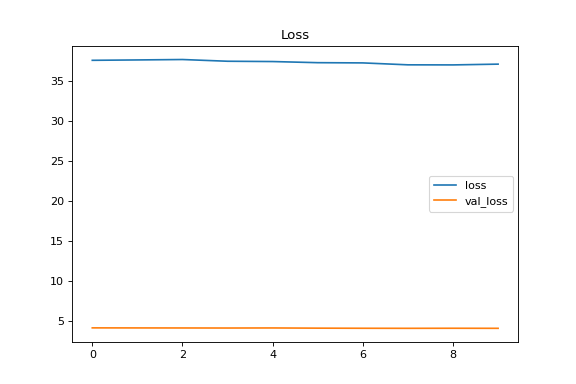

<IPython.core.display.Javascript object>


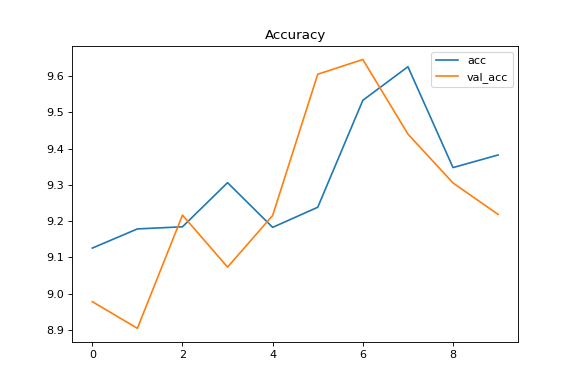

<IPython.core.display.Javascript object>


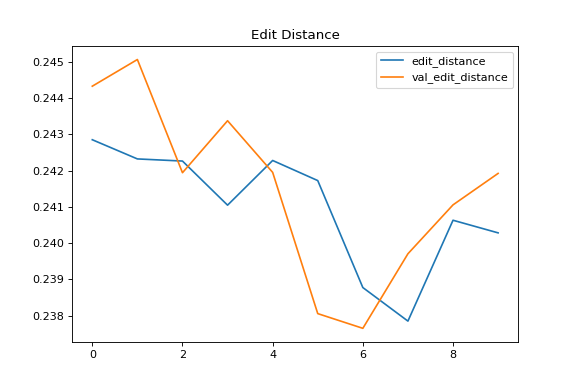

In [46]:
%reload_ext autoreload


train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)
val_dataset = CustomAudioDataset(X_val, Y_val, uids_val)

history, test_out, start_time, end_time = tweetynet.train_pipeline(train_dataset, val_dataset, test_dataset, 
                                                                   lr=.001, batch_size=128,epochs=10, save_me=True,
                                                                   fine_tuning=False, finetune_path=None)

In [47]:
len(train_dataset)

2214

In [48]:
end_time - start_time

datetime.timedelta(seconds=2959, microseconds=765024)

In [49]:
test_out


uid  zero_pred  one_pred  \
0      XC101694 - Slate-throated Whitestart - Myiobor...   0.641468 -0.636865   
1      XC101694 - Slate-throated Whitestart - Myiobor...   0.777475 -0.876293   
2      XC101694 - Slate-throated Whitestart - Myiobor...   0.739783 -0.744233   
3      XC101694 - Slate-throated Whitestart - Myiobor...   0.681938 -0.647567   
4      XC101694 - Slate-throated Whitestart - Myiobor...   0.676270 -0.632735   
...                                                  ...        ...       ...   
14971  XC504735 - Scaly-breasted Woodpecker - Celeus ...   1.212634 -0.714372   
14972  XC504735 - Scaly-breasted Woodpecker - Celeus ...   1.331883 -0.827214   
14973  XC504735 - Scaly-breasted Woodpecker - Celeus ...   0.969760 -0.763867   
14974  XC504735 - Scaly-breasted Woodpecker - Celeus ...   1.133402 -0.647657   
14975  XC504735 - Scaly-breasted Woodpecker - Celeus ...   1.077399 -0.644394   

       pred  label  
0        10      2  
1        10      2  
2        10      2  
3        10      2  
4        10      2  
...     ...    ...  
14971    10     10  
14972    10     10  
14973    10     10  
14974    10     10  
14975    10     10  

[88704 rows x 5 columns]

In [50]:
chunked_renamed_df.to_csv("formated_tweetynet_ground_truth.csv")

# Visualization

In [51]:
#should categorize this data

In [52]:
a, sr = librosa.load(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))
sr

NameError: name 'folder_name' is not defined

In [ ]:
#-100,-2
idx_here = -100
x = X[idx_here]
y = Y[idx_here]
uid = uids[idx_here]
folder_name = "ff1010bird_wav" if "-" not in uid else "warblrb10k_public_wav"
sr = 44100
x.shape

In [ ]:
show_mel_spectrogram(x.transpose(), uid)
y, uid

In [ ]:
ipd.Audio(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(a, sr=sr)

In [53]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
species

In [ ]:
32 * 144


In [ ]:
temp_uids.flatten().shape

In [56]:
test = output[:, 0, :].numpy()



d = {}
label_d = {}
scores = []

label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))

for species_index in range(output.shape[1]):
    print(species_index)
    test = output[:, species_index, :].numpy()
    print(test.shape)
    count = 0
    scores = []
    
    d["uid"] =  temp_uids.flatten()
    print(d["uid"].shape[0])
    
    for file in test:
        for slice_ in file:
            scores.append(slice_)
            count += 1
    d[species[species_index]] = scores
    print(species[species_index], count, len( d[species[species_index]]))
    
    


for key in d:
    print(len(d[key]))

new_preds = pd.DataFrame(d)
new_preds

AttributeError: 'CustomAudioDataset' object has no attribute 'len_of_labels'

In [ ]:
output[:, 0, :].shape